In [4]:
import numpy as np  # Importing numpy library for linear algebra operations
import pandas as pd  # Importing pandas library for data processing and CSV file I/O
import os  # Importing os module for operating system functionality
import cv2  # Importing OpenCV library for image processing
import matplotlib.pyplot as plt  # Importing matplotlib for visualization
from sklearn.model_selection import train_test_split  # Importing train_test_split function from sklearn
from keras.optimizers import Adam  # Importing Adam optimizer from Keras
from keras import backend as K  # Importing Keras backend module
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, BatchNormalization, LeakyReLU  # Importing necessary layers from Keras
from keras.layers import concatenate  # Importing concatenate function for merging layers
from keras.models import Model  # Importing Model class from Keras for creating neural network models
from keras.preprocessing.image import ImageDataGenerator  # Importing ImageDataGenerator for data augmentation
import tensorflow as tf  # Importing TensorFlow library

tf.random.set_seed(123)  # Setting random seed for reproducibility
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.random.set_seed(2)  # Setting random seed for TensorFlow

# Printing the list of files/directories in the specified directory
print(os.listdir("dataset/dataset/dataset_updated/"))


['training_set', 'validation_set']


In [5]:
ImagePath="dataset/dataset/dataset_updated/training_set/painting/"

(224, 224, 3)

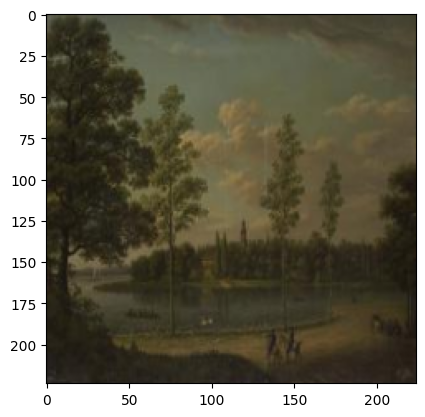

In [6]:
img = cv2.imread(ImagePath+"1179.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)
img.shape

In [7]:
HEIGHT=224
WIDTH=224
ImagePath="dataset/dataset/dataset_updated/training_set/painting/"

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for imageDir in os.listdir(ImagePath):
        try:
            img = cv2.imread(ImagePath + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            #Convert the rgb values of the input image to the range of 0 to 1
            #1.0/255 indicates that we are using a 24-bit RGB color space.
            #It means that we are using numbers between 0–255 for each color channel
            #img_lab = 1.0/225*img_lab
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            #img_l -= 50 # subtract 50 for mean-centering
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [8]:
X_,y_ = ExtractInput(ImagePath) # Data-preprocessing

In [9]:
#X_train,X_val,y_train,y_val = train_test_split(X_,y_, random_state=42)

In [10]:
K.clear_session()
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    concat_ = concatenate([model_, in_]) 
    
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [11]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [12]:
LEARNING_RATE = 0.1
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss='mean_squared_error')
Model_Colourization.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 16)         160       ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 32)         4640      ['leaky_re_lu[0][0]']         
                                                                                              

In [13]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,224,224,1)
        y_input = y_[i].reshape(1,224,224,2)
        yield (X_input,y_input)
Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=53,verbose=1,steps_per_epoch=38,shuffle=True)#,validation_data=GenerateInputs(X_val, y_val))

C:\Users\aksha\AppData\Local\Temp\ipykernel_3608\2568210341.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=53,verbose=1,steps_per_epoch=38,shuffle=True)#,validation_data=GenerateInputs(X_val, y_val))


Epoch 1/53



38/38 [==============================] - 151s 4s/step - loss: 0.0543
Epoch 2/53
38/38 [==============================] - 99s 3s/step - loss: 0.0090
Epoch 3/53
38/38 [==============================] - 150s 4s/step - loss: 0.0024
Epoch 4/53
38/38 [==============================] - 147s 4s/step - loss: 0.0014
Epoch 5/53
38/38 [==============================] - 160s 4s/step - loss: 8.3584e-04
Epoch 6/53
24/38 [=================>............] - ETA: 58s - loss: 8.5507e-04 

In [ ]:
TestImagePath="dataset/dataset/dataset_updated/training_set/iconography/"

In [ ]:
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    #img_l -= 50
    img_l_reshaped = img_l.reshape(1,224,224,1)
    
    return img_l_reshaped

In [ ]:
ImagePath=TestImagePath+"15.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(224,224,2)

NameError: name 'cv2' is not defined

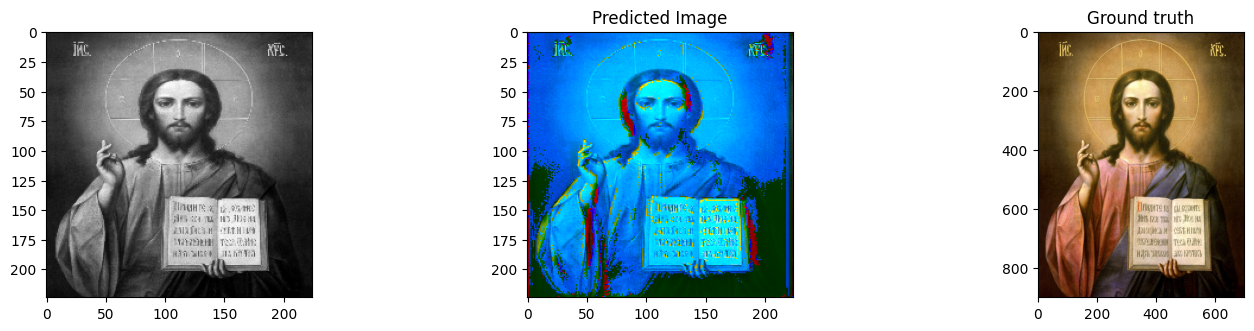

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"15.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [ ]:
ImagePath=TestImagePath+"314.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction_1 = Model_Colourization.predict(image_for_test)
Prediction_1 = Prediction_1*128
Prediction_1=Prediction_1.reshape(224,224,2)

1/1 [==============================] - 1s 1s/step


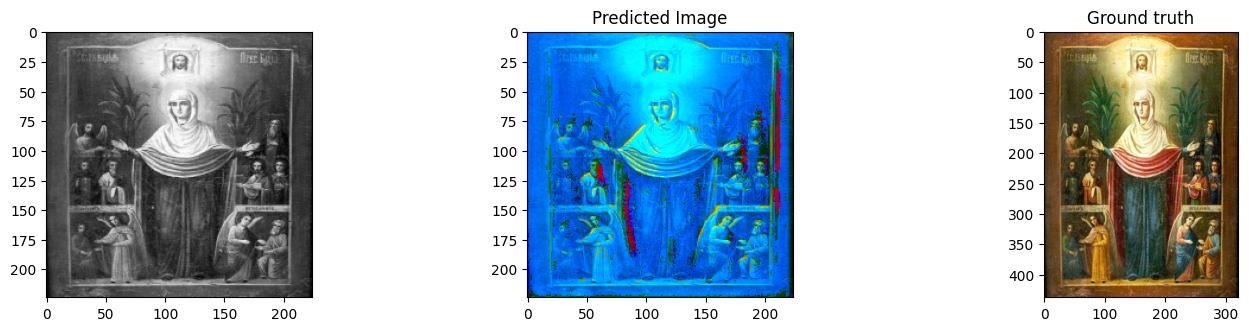

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"314.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_1
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [ ]:
ImagePath=TestImagePath+"698.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction_2 = Model_Colourization.predict(image_for_test)
Prediction_2 = Prediction_2*128
Prediction_2=Prediction_2.reshape(224,224,2)

1/1 [==============================] - 1s 960ms/step


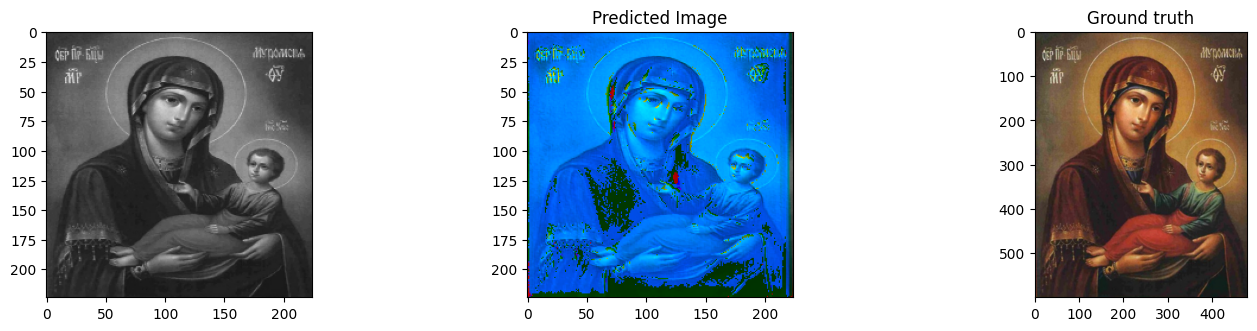

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"698.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_2
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [ ]:
TestImagePath="dataset/dataset/dataset_updated/training_set/sculpture/240.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_3 = Model_Colourization.predict(image_for_test)
Prediction_3 = Prediction_3*128
Prediction_3=Prediction_3.reshape(224,224,2)

1/1 [==============================] - 1s 1s/step


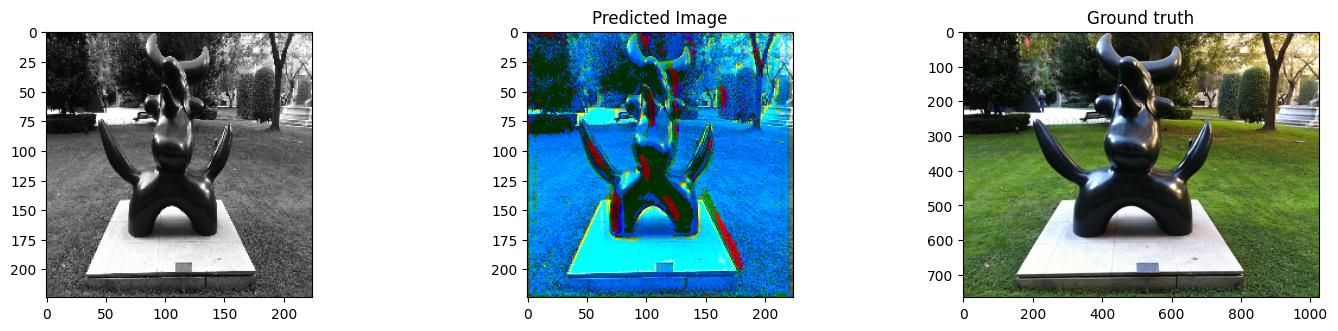

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_3
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [ ]:
TestImagePath="dataset/dataset/dataset_updated/training_set/painting/1601.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_4 = Model_Colourization.predict(image_for_test)
Prediction_4 = Prediction_4*128
Prediction_4=Prediction_4.reshape(224,224,2)

1/1 [==============================] - 1s 984ms/step


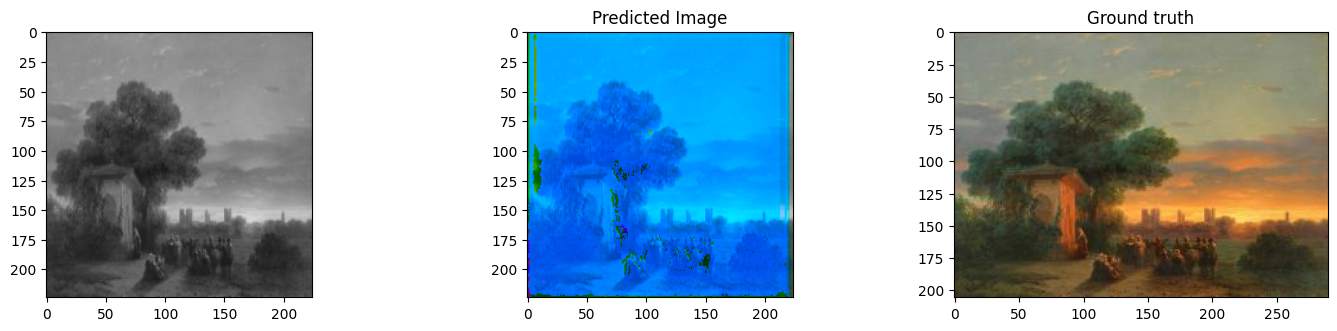

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_4
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [ ]:
TestImagePath="dataset/dataset/dataset_updated/training_set/painting/1577.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_5 = Model_Colourization.predict(image_for_test)
Prediction_5 = Prediction_5*128
Prediction_5=Prediction_5.reshape(224,224,2)

1/1 [==============================] - 1s 917ms/step


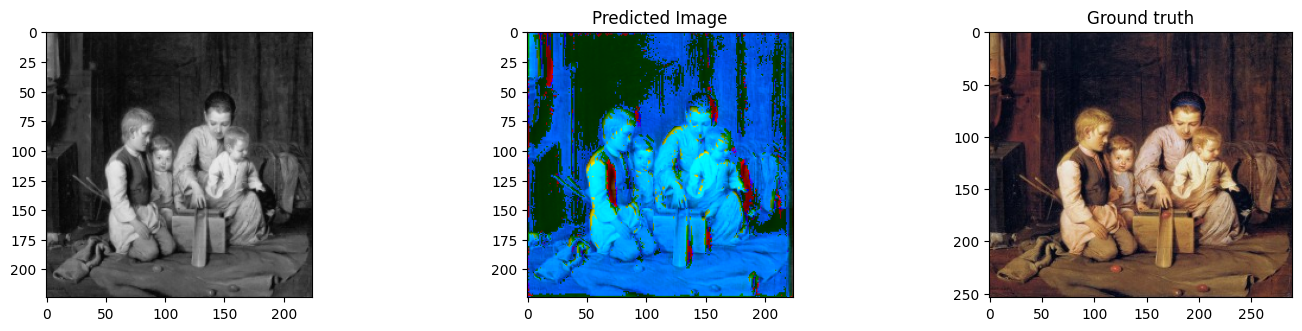

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_5
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)